In [1]:
from collections import Counter
import numpy as np
from codecs import open


In [2]:
# Function to read documents
def read_documents(doc_file):
    docs = []
    labels = []
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:  
                category_label = parts[0]
                sentiment_label = parts[1]
                words = parts[3:]
                docs.append(words)
                labels.append(sentiment_label)
    return docs, labels


In [15]:
def train_nb(documents, labels, alpha=1.0):
    # Combine all documents and labels
    all_words = [word for doc in documents for word in doc]
    all_labels = labels

    # Count occurrences of each word in positive and negative documents
    positive_counts = Counter()
    negative_counts = Counter()

    for i, label in enumerate(all_labels):
        for word in documents[i]:
            if label == 'pos':
                positive_counts[word] += 1
            elif label == 'neg':
                negative_counts[word] += 1

    # Calculate the total number of unique words
    vocabulary = set(all_words)
    V = len(vocabulary)

    total_docs = len(all_labels)
    p_pos = np.log(sum(1 for label in all_labels if label == 'pos') / total_docs)
    p_neg = np.log(sum(1 for label in all_labels if label == 'neg') / total_docs)

    # Calculate word probabilities with Laplace smoothing
    probabilities = {
        'pos': {word: np.log((positive_counts[word] + alpha) / (sum(positive_counts.values()) + alpha * V)) for word in vocabulary},
        'neg': {word: np.log((negative_counts[word] + alpha) / (sum(negative_counts.values()) + alpha * V)) for word in vocabulary}
    }

    return p_pos, p_neg, probabilities  # Return p_pos, p_neg, and probabilities



In [16]:
# Test the code again
all_docs, all_labels = read_documents('all_sentiment_shuffled.rtf')
split_point = int(0.80 * len(all_docs))
train_docs, train_labels = all_docs[:split_point], all_labels[:split_point]

# Train the Naive Bayes model
p_pos, p_neg, probabilities = train_nb(train_docs, train_labels)

# Print some probabilities for sanity check
print("Positive probability of 'great':", probabilities['pos']['great'])
print("Negative probability of 'bad':", probabilities['neg']['bad'])

Positive probability of 'great': -5.9592668005080265
Negative probability of 'bad': -6.99266277534879


In [17]:
def score_doc_label(document, label, probabilities):
    log_prob = 0.0
    for word in document:
        if word in probabilities[label]:
            log_prob += np.log(probabilities[label][word])
    return log_prob


In [18]:
def classify_nb(document, probabilities):
    pos_score = score_doc_label(document, 'pos', probabilities)
    neg_score = score_doc_label(document, 'neg', probabilities)
    
    if pos_score > neg_score:
        return 'pos'
    else:
        return 'neg'


In [19]:
def classify_documents(docs, probabilities):
    predictions = [classify_nb(doc, probabilities) for doc in docs]
    return predictions


In [20]:
def accuracy(true_labels, guessed_labels):
    correct = sum(1 for true, guessed in zip(true_labels, guessed_labels) if true == guessed)
    total = len(true_labels)
    return correct / total


In [21]:
# Evaluate the classifier
eval_docs, eval_labels = all_docs[split_point:], all_labels[split_point:]
predictions = classify_documents(eval_docs, probabilities)

# Calculate accuracy
acc = accuracy(eval_labels, predictions)
print("Accuracy on the evaluation set:", acc)


C:\Users\katre\AppData\Local\Temp\ipykernel_19164\4124690707.py:5: RuntimeWarning: invalid value encountered in log
  log_prob += np.log(probabilities[label][word])


Accuracy on the evaluation set: 0.5161561057490558


In [22]:
# Evaluate the classifier
eval_docs, eval_labels = all_docs[split_point:], all_labels[split_point:]
predictions = classify_documents(eval_docs, probabilities)

# Error Analysis
misclassified_docs = [(doc, true, pred) for doc, true, pred in zip(eval_docs, eval_labels, predictions) if true != pred]
for doc, true, pred in misclassified_docs:
    print(f"True Label: {true}, Predicted Label: {pred}, Document: {' '.join(doc)}")

# Calculate accuracy
acc = accuracy(eval_labels, predictions)
print("Accuracy on the evaluation set:", acc)


C:\Users\katre\AppData\Local\Temp\ipykernel_19164\4124690707.py:5: RuntimeWarning: invalid value encountered in log
  log_prob += np.log(probabilities[label][word])


True Label: pos, Predicted Label: neg, Document: the series just keeps on getting better . the bob newhart show was one of the best comedies ever on television . the other funny show was " newhart " , which i cannot understand why it has not been released on dvd . the whole cast just clicks . i wish shows like this were still on television . if you enjoy a good laugh then buy this and the other sets ! \
True Label: pos, Predicted Label: neg, Document: i highly recommend this super wide angle lens for anyone wanting to take landscape pictures , buildings or lots of other stuff ! it is so different than the standard kit lens ( 18-55 ) . you wo n't be sorry when you start learning all the possibilities of the extraordinary lens \
True Label: pos, Predicted Label: neg, Document: this is one of the better historical dramas from the 1970s . many are stagey and slow , and while this production of madame bovary is very much constrained to stay indoors , this works to advantage for this story o

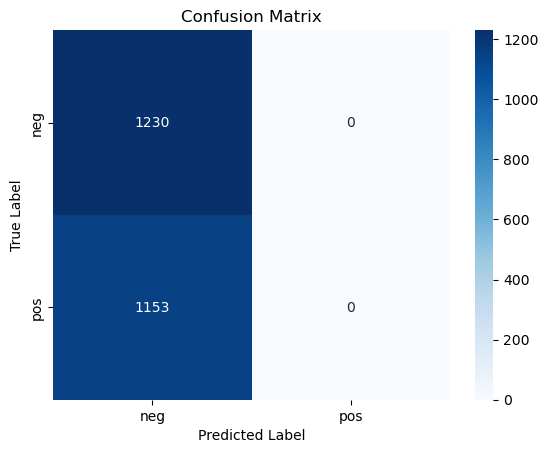

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(eval_labels, predictions)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


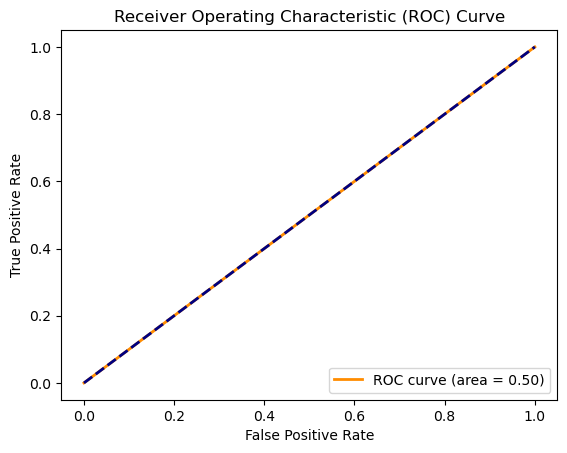

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Convert labels to binary numeric values
eval_labels_numeric = np.where(np.array(eval_labels) == 'pos', 1, 0)
predictions_numeric = np.where(np.array(predictions) == 'pos', 1, 0)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(eval_labels_numeric, predictions_numeric)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [24]:
# Cross-Validation
N = 5  
accuracies = []

for fold_nbr in range(N):
    split_point_1 = int(float(fold_nbr) / N * len(all_docs))
    split_point_2 = int(float(fold_nbr + 1) / N * len(all_docs))

    train_docs_fold = all_docs[:split_point_1] + all_docs[split_point_2:]
    train_labels_fold = all_labels[:split_point_1] + all_labels[split_point_2:]
    eval_docs_fold = all_docs[split_point_1:split_point_2]

    # Train the Naive Bayes model
    p_pos, p_neg, probabilities_fold = train_nb(train_docs_fold, train_labels_fold)

    # Evaluate the classifier
    predictions_fold = classify_documents(eval_docs_fold, probabilities_fold)

    # Calculate accuracy for this fold
    acc_fold = accuracy(all_labels[split_point_1:split_point_2], predictions_fold)
    accuracies.append(acc_fold)

# Calculate the overall accuracy
avg_accuracy = np.mean(accuracies)
print("Cross-Validation Accuracy:", avg_accuracy)


C:\Users\katre\AppData\Local\Temp\ipykernel_19164\4124690707.py:5: RuntimeWarning: invalid value encountered in log
  log_prob += np.log(probabilities[label][word])


Cross-Validation Accuracy: 0.49630671778441826
